In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import sys
sys.path.append("/home/z5297792/UNSW-MRes/MRes/modules") 
from utils import plot_ellipse, dopioe, gaussian_vel_reconstruction, find_directional_radii, calc_tang_vel

import re
def extract_number(s):
    match = re.search(r'\d+', s)
    return int(match.group()) if match else None


In [2]:
def find_root(x, y):
    coeffs = np.polyfit(x, y, 3)
    roots = np.roots(np.poly1d(coeffs))
    real_roots = roots[np.isreal(roots)].real
    mid = x[len(x)//2]
    return real_roots[np.argmin(np.abs(mid - real_roots))]

def tang_at_root(x, y, rx):
    coeffs = np.polyfit(x, y, 3)
    deriv = np.polyder(coeffs)
    slope = np.polyval(deriv, rx)
    intercept = np.polyval(coeffs, rx) - slope * rx
    return slope, intercept

def cubic_interpolate(x, y, root):
    coeffs = np.polyfit(x, y, 3)
    return np.polyval(coeffs, root)
    

In [3]:
width=500
x = np.linspace(-width // 2, width // 2, 101)
y = np.linspace(-width // 2, width // 2, 101)
X, Y = np.meshgrid(x, y, indexing='ij')

psi0 = 200
Rc = 100
xc, yc = 0.0, 0.0
q11, q12, q22 = 2.0, 1.0, 2.0

dx, dy = X-xc, Y-yc
rho      = q11*dx**2 + 2*q12*dx*dy + q22*dy**2
rho_x    = 2*q11*dx   + 2*q12*dy
rho_y    = 2*q12*dx   + 2*q22*dy
exp_t    = np.exp(-rho/Rc**2)
u   =  psi0/Rc**2 * rho_y * exp_t
v   = -psi0/Rc**2 * rho_x * exp_t

s = -psi0 / Rc**2
Q11, Q12, Q22 = s*q11, s*q12, s*q22

df_res = pd.DataFrame(columns=['xc', 'yc', 'w', 'Q11', 'Q12', 'Q22', 'Rc', 'psi0', 'q11', 'q12', 'q22'])
df_res.loc[len(df_res)] = {'xc': xc, 'yc': yc, 'w': 2*(Q11+Q22),
                           'Q11': Q11, 'Q12': Q12, 'Q22': Q22, 
                           'Rc': Rc, 'psi0': psi0, 'q11': q11, 'q12': q12, 'q22': q22}


In [4]:
nic, njc = 53, 53
r = 8

df_tests = pd.DataFrame({
    'nic': [nic, 42, 39, nic, nic, nic],
    'njc': [njc, 58, 39, njc, njc, njc],
    'r': [r, r, r, r-2, r, r+2]
}, index=['P1', 'P2', 'P3', 'L1', 'L2', 'L3'])


dic_tests = {}
for test in df_tests.index:
    data = df_tests.loc[test]

    x1 = x[data.nic-data.r:data.nic+data.r+1]
    y1 = np.array([y[data.njc]] * len(x1))

    u1 = u[data.nic-data.r:data.nic+data.r+1, data.njc]
    v1 = v[data.nic-data.r:data.nic+data.r+1, data.njc]

    y2 = y[data.njc-data.r:data.njc+data.r+1]
    x2 = np.array([x[data.nic]] * len(y2))

    u2 = u[data.nic, data.njc-data.r:data.njc+data.r+1]
    v2 = v[data.nic, data.njc-data.r:data.njc+data.r+1]

    xc_rel, yc_rel, w_rel, Q_rel, Rc_rel, psi0_rel, q_rel = dopioe(x1, y1, u1, v1, x2, y2, u2, v2)
    
    # radii = find_directional_radii(u, v, X, Y, xc, yc, calc_tang_vel)
    # Rc_rel = np.mean([radii['up'], radii['right'], radii['down'], radii['left']])
    
    dic_tests[test] = {'x1': x1, 'y1': y1, 'u1': u1, 'v1': v1,
                       'x2': x2, 'y2': y2, 'u2': u2, 'v2': v2,
                       'name': test}
    df_res.loc[len(df_res)] = {'xc': xc_rel, 'yc': yc_rel, 'w': w_rel,
                               'Q11': Q_rel[0,0], 'Q12': Q_rel[0,1], 'Q22': Q_rel[1,1],
                               'Rc': Rc_rel, 'psi0': psi0_rel,
                               'q11': q_rel[0,0], 'q12': q_rel[1,0], 'q22': q_rel[1,1]}
df_res.index = ['Control'] +  list(df_tests.index)
df_res


,xc,yc,w,Q11,Q12,Q22,Rc,psi0,q11,q12,q22
Control,0.000000,0.000000,-0.160000,-0.040000,-0.020000,-0.040000,100.000000,200.000000,2.000000,1.000000,2.000000
P1,-0.270475,-0.270475,-0.151134,-0.037784,-0.018815,-0.037784,43.068533,210.785915,0.332492,0.165574,0.332492
P2,2.120287,-2.120287,-0.122039,-0.030510,-0.015538,-0.030510,42.173620,283.569089,0.191365,0.097457,0.191365
P3,-17.811930,-17.811930,-0.155822,-0.038955,-0.003260,-0.038955,37.876389,115.104592,0.485526,0.040628,0.485526
L1,-0.082905,-0.082905,-0.156602,-0.039151,-0.019621,-0.039151,42.826782,205.703597,0.349082,0.174952,0.349082
L2,-0.270475,-0.270475,-0.151134,-0.037784,-0.018815,-0.037784,43.068533,210.785915,0.332492,0.165574,0.332492
L3,-0.419415,-0.419415,-0.144508,-0.036127,-0.017834,-0.036127,43.260692,213.434497,0.316778,0.156380,0.316778


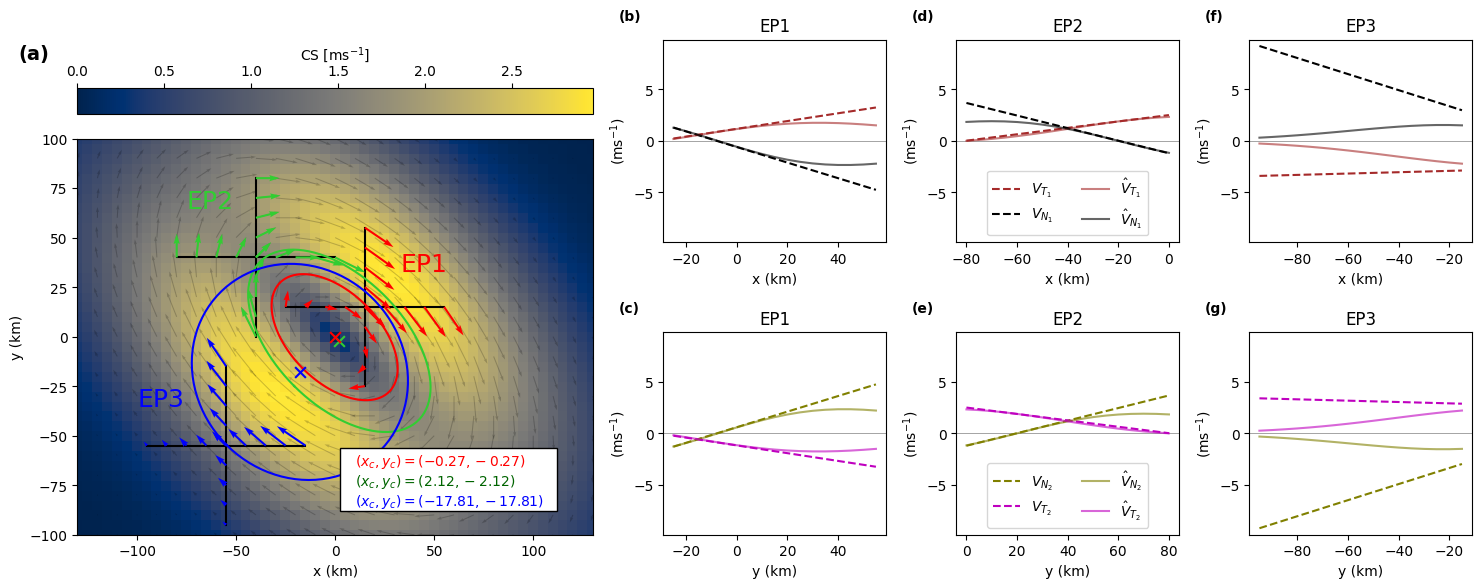

In [5]:
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle

fig = plt.figure(figsize=(15, 6))

gs = gridspec.GridSpec(2, 5, figure=fig)
ax_main = fig.add_subplot(gs[:2, :2])
cmap = 'cividis'
spacing, scale, width = 2, 40, 0.002 #0.004
pc = ax_main.pcolor(x, y, np.hypot(u, v).T, cmap=cmap)
plt.colorbar(pc, ax=ax_main, orientation='horizontal', location='top', label='CS [ms$^{-1}$]')
ax_main.quiver(x[::spacing], y[::spacing], u[::spacing, ::spacing].T, v[::spacing, ::spacing].T, 
               alpha=0.2, scale=scale, width=width)


# colours = ['r', 'darkgreen', 'b']
colours = ['r', 'limegreen', 'b']

i = 0
scales = [40, 58, 65]
for dic in dic_tests.values():
    if 'P' in dic['name']:

        x1, y1, u1, v1, x2, y2, u2, v2 = (dic[k] for k in ['x1', 'y1', 'u1', 'v1', 'x2', 'y2', 'u2', 'v2'])
        data = df_res.loc[dic['name']]
 
        ax_main.plot(x1, y1, 'k', zorder=1)
        ax_main.plot(x2, y2, 'k', zorder=1)

        ax_main.quiver(x1[::spacing], y1[::spacing], u1[::spacing], v1[::spacing], scale=scale, width=width*2, color=colours[i])
        ax_main.quiver(x2[::spacing], y2[::spacing], u2[::spacing], v2[::spacing], scale=scale, width=width*2, color=colours[i])
        ax_main.scatter(data.xc, data.yc, marker='x', s=60, color=colours[i], zorder=10-extract_number(dic['name']))

        Q = np.array([[data.Q11, data.Q12], [data.Q12, data.Q22]])
        x_ellipse, y_ellipse = plot_ellipse(Q, center=(data.xc, data.yc), scale=scales[i])
        ax_main.plot(x_ellipse, y_ellipse, color=colours[i])
        
        ax_main.text(10, -65 - 10*i, fr'$(x_c,y_c)=({data.xc:.2f},{data.yc:.2f})$', color='darkgreen' if '2' in dic['name'] else colours[i], zorder=11)
        i += 1

x_pos, y_pos = 0.72, 0.14
box_width = 0.42  # Adjust width as needed
box_height = 0.16 #0.07  # Adjust height as needed
rect = Rectangle((x_pos - box_width / 2, y_pos - box_height / 2), 
                       box_width, box_height, transform=ax_main.transAxes,
                       facecolor='white', edgecolor='black', zorder=10)
ax_main.add_patch(rect)
        
ax_main.text(-160, 140, '(a)', fontsize=14, fontweight='bold')  # Adjust coordinates as needed
ax_main.axis('equal')
ax_main.set_xlim(-100, 100)
ax_main.set_ylim(-100, 100)
ax_main.set_xlabel('x (km)')
ax_main.set_ylabel('y (km)')

axs = []
j = 2 
i = 0
tags = [('(b)','(c)', 'EP1'), ('(f)','(g)', 'EP3'), ('(d)','(e)', 'EP2')]
for dic in dic_tests.values():
    if 'P' in dic['name']:

        x1, y1, u1, v1, x2, y2, u2, v2 = (dic[k] for k in ['x1', 'y1', 'u1', 'v1', 'x2', 'y2', 'u2', 'v2'])
        data = df_res.loc[dic['name']]
        ax2 = fig.add_subplot(gs[0, j])
        ax3 = fig.add_subplot(gs[1, j])
    
        root_x = find_root(x1, v1)
        A1, A0 = tang_at_root(x1, u1, root_x)
        B1, B0 = tang_at_root(x1, v1, root_x)
        p_u1 = A1*x1 + A0
        p_v1 = B1*x1 + B0

        root_y = find_root(y2, u2)
        C1, C0 = tang_at_root(y2, u2, root_y)
        D1, D0 = tang_at_root(y2, v2, root_y)
        p_u2 = C1*y2 + C0
        p_v2 = D1*y2 + D0
    
        ax2.plot(x1, p_u1, linestyle='--', color='brown', label=r'$V_{T_1}$')
        ax2.plot(x1, p_v1, 'k--', label=r'$V_{N_1}$')
        ax2.plot(x1, u1, color='brown', label=r'$\hat{V}_{T_1}$', alpha=.6)#, color=colours[i])
        ax2.plot(x1, v1, 'k', label=r'$\hat{V}_{N_1}$', alpha=.6)#, color=colours[i+1])
        ax2.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
        ax2.set_ylabel('(ms$^{-1}$)')
        ax2.set_xlabel(r'x (km)')
        if '2' in dic['name']:
            ax2.legend(loc='lower center', ncol=2)
        ax2.set_title(tags[2-j][2])
        ax2.text(-0.2, 1.15, tags[2-j][0], transform=ax2.transAxes, fontsize=10, fontweight='bold', va='top', ha='left')#, color=colours[i])
        
        ax3.plot(y2, p_u2, linestyle='--', color='olive', label=r'$V_{N_2}$')
        ax3.plot(y2, p_v2, 'm--', label=r'$V_{T_2}$')
        ax3.plot(y2, u2, color='olive', label=r'$\hat{V}_{N_2}$', alpha=.6)#, color=colours[i])
        ax3.plot(y2, v2, 'm', label=r'$\hat{V}_{T_2}$', alpha=.6)#, color=colours[i+1])
        ax3.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
        ax3.set_ylabel('(ms$^{-1}$)')
        ax3.set_xlabel(r'y (km)')
        if '2' in dic['name']:
            ax3.legend(loc='lower center', ncol=2)
        ax3.set_title(tags[2-j][2])
        ax3.text(-0.2, 1.15, tags[2-j][1], transform=ax3.transAxes, fontsize=10, fontweight='bold', va='top', ha='left')#, color=colours[i])

        axs.extend([ax2, ax3])
        j += 1
        i += 1
        
ymin, ymax = min(ax.get_ylim()[0] for ax in axs), max(ax.get_ylim()[1] for ax in axs)
for ax in axs:
    ax.set_ylim(ymin, ymax)

ax_main.text(33, 33, 'EP1', color='r', zorder=3, fontsize=18)
ax_main.text(-75, 65, 'EP2', color='limegreen', zorder=3, fontsize=18)
ax_main.text(-100, -35, 'EP3', color='b', zorder=3, fontsize=18)

plt.tight_layout()
plt.show()


In [6]:
df_res


,xc,yc,w,Q11,Q12,Q22,Rc,psi0,q11,q12,q22
Control,0.000000,0.000000,-0.160000,-0.040000,-0.020000,-0.040000,100.000000,200.000000,2.000000,1.000000,2.000000
P1,-0.270475,-0.270475,-0.151134,-0.037784,-0.018815,-0.037784,43.068533,210.785915,0.332492,0.165574,0.332492
P2,2.120287,-2.120287,-0.122039,-0.030510,-0.015538,-0.030510,42.173620,283.569089,0.191365,0.097457,0.191365
P3,-17.811930,-17.811930,-0.155822,-0.038955,-0.003260,-0.038955,37.876389,115.104592,0.485526,0.040628,0.485526
L1,-0.082905,-0.082905,-0.156602,-0.039151,-0.019621,-0.039151,42.826782,205.703597,0.349082,0.174952,0.349082
L2,-0.270475,-0.270475,-0.151134,-0.037784,-0.018815,-0.037784,43.068533,210.785915,0.332492,0.165574,0.332492
L3,-0.419415,-0.419415,-0.144508,-0.036127,-0.017834,-0.036127,43.260692,213.434497,0.316778,0.156380,0.316778


### Pres Plots

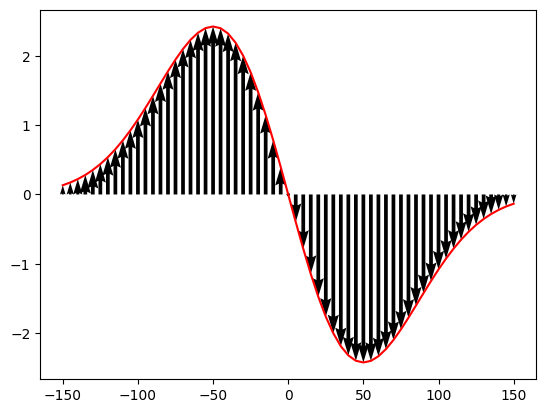

In [7]:
data = pd.DataFrame({'nic': [50], 'njc': [50], 'r': [30]}).iloc[0]

x1 = x[data.nic-data.r:data.nic+data.r+1]
y1 = np.array([y[data.njc]] * len(x1))

u1 = u[data.nic-data.r:data.nic+data.r+1, data.njc]
v1 = v[data.nic-data.r:data.nic+data.r+1, data.njc]


plt.quiver(x1, [0]*len(x1), [0]*len(v1), v1, scale_units='xy', scale=1)
plt.plot(x1, v1, color='r') 



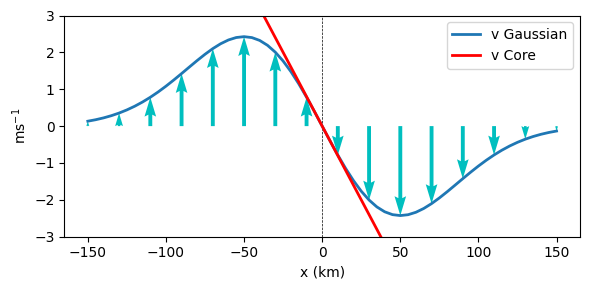

In [8]:
plt.figure(figsize=(6,3))
plt.axvline(x=0, color='k', linewidth=.5, linestyle='--')
plt.plot(x1, v1, linewidth=2, label='v Gaussian')
spac = 4
plt.quiver(x1[::spac], [0]*len(x1[::spac]), [0]*len(v1[::spac]), v1[::spac], scale_units='xy', scale=1, color='c')

s = -psi0/Rc**2 
Q11, Q12, Q22 = s*q11, s*q12, s*q22
vcore = 2*Q11*(x1-xc) + 2*Q12*(y1-yc)
plt.plot(x1, vcore, 'r-', linewidth=2, label='v Core')

# # Fit line 
# m, b = np.polyfit(x1, v1, 1)
# y_fit = m * x1 + b
# plt.plot(x1, y_fit, 'k--') 
plt.legend()
plt.xlabel(r'x (km)')
plt.ylabel(r'ms$^{-1}$')
plt.ylim(-3, 3)
plt.tight_layout()


In [9]:
vcore

array([ 12. ,  11.6,  11.2,  10.8,  10.4,  10. ,   9.6,   9.2,   8.8,
         8.4,   8. ,   7.6,   7.2,   6.8,   6.4,   6. ,   5.6,   5.2,
         4.8,   4.4,   4. ,   3.6,   3.2,   2.8,   2.4,   2. ,   1.6,
         1.2,   0.8,   0.4,  -0. ,  -0.4,  -0.8,  -1.2,  -1.6,  -2. ,
        -2.4,  -2.8,  -3.2,  -3.6,  -4. ,  -4.4,  -4.8,  -5.2,  -5.6,
        -6. ,  -6.4,  -6.8,  -7.2,  -7.6,  -8. ,  -8.4,  -8.8,  -9.2,
        -9.6, -10. , -10.4, -10.8, -11.2, -11.6, -12. ])